In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report
import os
from transformers import Trainer, TrainingArguments
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import pandas as pd
label_map = {
    'affected_individuals': 0,
    'infrastructure_and_utility_damage': 1,
    'not_humanitarian': 2,
    'other_relevant_information': 3,
    'rescue_volunteering_or_donation_effort': 4,
    'vehicle_damage': 1,
    'injured_or_dead_people': 0,
    'missing_or_found_people': 0
}

In [2]:
class NPZLoader(Dataset):
    def __init__(self, img_embed_filename,text_emb_filename,tsv_file, transform=None):
#        self.files = list(Path(path).glob('*/*.npz'))
#        self.transform = transform
        self.text_embed = torch.load(text_embed_filename).mean(axis=1) # ../sporwal9/eng_test_data_emb.pt
        self.img_emb = np.load(img_embed_filename) #image_model_ouputs/resnet18_image_embedding_512_test.npz
        self.original_df = pd.read_csv(tsv_file, sep='\t') #'../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv'
        self.df = self.original_df.loc[original_df.label_text_image=="Positive"]
        id_list=  list(self.df['tweet_id'].unique())
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_tweetID = self.img_emb['image_tweetID'][idx]
        
        image_embedding = torch.from_numpy(self.img_emb['image_embedding'][idx].squeeze(1))
        
        text_embedding = self.text_embed[idx].unsqueeze(1)
        fusion_emb = torch.cat((text_embedding.cuda(),image_embedding.cuda()),dim=0)
        label = self.df.loc[self.df['tweet_id']==image_tweetID,'label'][0]
        if image_tweetID in id_list :
            return fusion_emb,image_tweetID,label


In [3]:
def AlignFormatLabels(list, labels):
    aligned_list = []
    for item in list:
        if item == 'vehicle_damage':
            aligned_list.append('infrastructure_and_utility_damage')
        elif item == 'missing_or_found_people' or item == 'injured_or_dead_people':
            aligned_list.append('affected_individuals')
        else:
            aligned_list.append(item)
    final_labels = []
    for item in aligned_list:
        final_labels.append(labels.index(item))
    return final_labels

my_labels = ['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
             'infrastructure_and_utility_damage', 'not_humanitarian']

## Pre-processing

In [4]:
test_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_test.tsv'
train_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv'
val_tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_dev.tsv'

df_test = pd.read_csv(test_tsv_file, sep='\t')
df_train = pd.read_csv(train_tsv_file, sep='\t')
df_val = pd.read_csv(val_tsv_file, sep='\t')

df_train.shape, df_test.shape, df_val.shape

((13608, 9), (2237, 9), (2237, 9))

In [5]:
df_train.head(2)

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative


In [6]:
# get training labels in right format
raw_train_labels = df_train[df_train.label_text_image == "Positive"]["label_text"]
train_labels = torch.Tensor(AlignFormatLabels(raw_train_labels, my_labels))

# get testing labels in right format
raw_test_labels = df_test[df_test.label_text_image == "Positive"]["label_text"]
test_labels = torch.Tensor(AlignFormatLabels(raw_test_labels, my_labels))

train_labels.to("cuda")
test_labels.to("cuda")

print(len(test_labels), len(train_labels))

955 6126


In [8]:
positive_ids_train = df_train.loc[df_train.label_text_image=="Positive"].index

In [9]:
text_emb_test_raw = torch.load('../sporwal9/hindi_test_data_emb.pt')
text_emb_train_raw = torch.load('../sporwal9/hindi_train_data_emb.pt')
# text_emb_val_raw = torch.load('../sporwal9/eng_dev_data_emb.pt')

In [10]:
text_emb_test = text_emb_test_raw.mean(axis=1).squeeze(1)
text_emb_train = text_emb_train_raw.mean(axis=1).squeeze(1)
# text_emb_val = text_emb_val_raw.mean(axis=1).squeeze(1)

In [11]:
text_emb_test.shape, text_emb_train.shape

(torch.Size([955, 256]), torch.Size([6126, 256]))

In [12]:
img_emb_test_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_test.npz")
img_emb_train_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_train.npz")
# img_emb_val_raw = np.load("image_model_ouputs/resnet18_image_embedding_512_dev.npz")

In [13]:
img_emb_test, img_tweetID_test = img_emb_test_raw['image_embedding'], img_emb_test_raw['image_tweetID']
img_emb_train, img_tweetID_train = img_emb_train_raw['image_embedding'], img_emb_train_raw['image_tweetID']
# img_emb_val, img_tweetID_val = img_emb_val_raw['image_embedding'], img_emb_val_raw['image_tweetID']

img_emb_test = torch.from_numpy(img_emb_test[0:955]).squeeze((2,3))
img_emb_train = torch.from_numpy(img_emb_train[0:13608]).squeeze((2,3))
# img_emb_val = torch.from_numpy(img_emb_val).squeeze((2,3))

img_emb_train = img_emb_train[positive_ids_train]

In [14]:
img_emb_test.shape, img_emb_train.shape

(torch.Size([955, 512]), torch.Size([6126, 512]))

In [15]:
img_tweetID_test.shape, img_tweetID_train.shape

((955,), (13608,))

In [16]:
X_train = torch.cat((text_emb_train.cuda(), img_emb_train.cuda()), dim=1)
X_test = torch.cat((text_emb_test.cuda(), img_emb_test.cuda()), dim=1)

# train_dataset = DatasetFormatting(X_train, train_labels)
# test_dataset = DatasetFormatting(X_test, test_labels)

In [17]:
X_train.shape, X_test.shape

(torch.Size([6126, 768]), torch.Size([955, 768]))

## Multimodal Network

In [18]:
in_features = 1024
h1 = 512
h2 = 128
h3 = 32
out_features = 5

print(in_features, h1, h2, h3, out_features)

1024 512 128 32 5


In [19]:
class Multimodal(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.multimodal = torch.nn.Sequential(
            # input layer
            torch.nn.Linear(X_train.shape[1], in_features),
            # dropout
            torch.nn.Dropout(0.1),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer1
            torch.nn.Linear(in_features, h1),
            # dropout
            torch.nn.Dropout(0.1),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer2
            torch.nn.Linear(h1, h2),
            # dropout
            torch.nn.Dropout(0.1),
            # ReLU activation
            torch.nn.ReLU(),
            # hidden_layer3
            torch.nn.Linear(h2, h3),
            # dropout
            torch.nn.Dropout(0.1),
            # ReLU activation
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(h3, out_features),
            # dropout
            torch.nn.Dropout(0.1)
        )
        
    def forward(self, x):
        return self.multimodal(x)
    
multimodal = Multimodal()
multimodal.to("cuda")

Multimodal(
  (multimodal): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): Dropout(p=0.1, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=5, bias=True)
    (13): Dropout(p=0.1, inplace=False)
  )
)

In [20]:
EPOCHS = 10
batch_size = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multimodal.parameters(), lr=0.0001)

In [21]:
losses = []

for epoch in range(EPOCHS):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = multimodal(Xbatch).type(torch.float64).to("cuda")
        ybatch = train_labels[i:i+batch_size].type(torch.LongTensor).to("cuda")
        loss = criterion(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach().numpy())
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 1.4322763030767136
Finished epoch 1, latest loss 1.2821620669858649
Finished epoch 2, latest loss 1.2010005788969205
Finished epoch 3, latest loss 1.1742892553103232
Finished epoch 4, latest loss 1.2401907230753073
Finished epoch 5, latest loss 1.0217047758695654
Finished epoch 6, latest loss 1.124539329677656
Finished epoch 7, latest loss 0.9308260122143253
Finished epoch 8, latest loss 0.8721712245402559
Finished epoch 9, latest loss 0.848270348596676


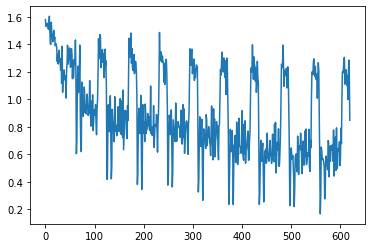

In [22]:
plt.plot(losses)

In [104]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred_train = multimodal(X_train).argmax(axis=1)
accuracy = (y_pred_train == train_labels.to("cuda")).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9764936566352844


In [105]:
target_names=['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
              'infrastructure_and_utility_damage', 'not_humanitarian']
print(classification_report(train_labels, y_pred_train.cpu(), target_names=target_names))

                                        precision    recall  f1-score   support

            other_relevant_information       0.96      1.00      0.98      1279
                  affected_individuals       0.62      0.97      0.75        71
rescue_volunteering_or_donation_effort       0.97      0.98      0.98       912
     infrastructure_and_utility_damage       0.96      0.97      0.96       612
                      not_humanitarian       1.00      0.97      0.98      3252

                              accuracy                           0.98      6126
                             macro avg       0.90      0.98      0.93      6126
                          weighted avg       0.98      0.98      0.98      6126



In [106]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = multimodal(X_test).argmax(axis=1)
accuracy = (y_pred == test_labels.to("cuda")).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.7078534364700317


In [107]:
target_names=['other_relevant_information', 'affected_individuals', 'rescue_volunteering_or_donation_effort', 
              'infrastructure_and_utility_damage', 'not_humanitarian']
print(classification_report(test_labels, y_pred.cpu(), target_names=target_names))

                                        precision    recall  f1-score   support

            other_relevant_information       0.66      0.73      0.69       235
                  affected_individuals       0.11      0.22      0.14         9
rescue_volunteering_or_donation_effort       0.65      0.63      0.64       126
     infrastructure_and_utility_damage       0.51      0.49      0.50        81
                      not_humanitarian       0.81      0.76      0.78       504

                              accuracy                           0.71       955
                             macro avg       0.55      0.57      0.55       955
                          weighted avg       0.72      0.71      0.71       955

